In [ ]:
# Importing libraries
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from matplotlib import pyplot
 
# Defining the discriminator model
def defineDiscriminator(imageShape):
    # Initialising weight
    init = RandomNormal(stddev=0.02)
    # Source image input
    inputImage = Input(shape=imageShape)
    # Convolutional layers
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(inputImage)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # Patch output
    patchOutput = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    # Defining model
    model = Model(inputImage, patchOutput)
    # Compiling model
    model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
    # Returning model to Training function
    return model
 
# Defining generator for ResNet block
def resnetBlock(nFilters, inputLayer):
    # Initialising weight
    init = RandomNormal(stddev=0.02)
    # Convolutional layers
    g = Conv2D(nFilters, (3,3), padding='same', kernel_initializer=init)(inputLayer)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    g = Conv2D(nFilters, (3,3), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    # Concatenating merge channel-wise with input layer
    g = Concatenate()([g, inputLayer])
    return g
 
# Defining the generator model
def defineGenerator(imageShape, nResNet=9):
    # Initialising weight
    init = RandomNormal(stddev=0.02)
    # Source image input
    inputImage = Input(shape=imageShape)
    # Convolutional layers
    g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(inputImage)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # Repeatedly defining ResNet 
    for _ in range(nResNet):
        # Using ResNet block
        g = resnetBlock(256, g)
    g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    out_image = Activation('tanh')(g)
    # Defining model
    model = Model(inputImage, out_image)
    # Returning model to Training function
    return model
 
# Defining a composite model for updating generators by adversarial and cycle loss
def defineCompositeModel(gModel1, dModel, gModel2, imageShape):
    # Ensuring the model we're updating is trainable
    gModel1.trainable = True
    # Marking discriminator as not trainable
    dModel.trainable = False
    # Marking the other generator model as not trainable
    gModel2.trainable = False
    # Discriminator element
    inputGenerator = Input(shape=imageShape)
    generator1Output = gModel1(inputGenerator)
    outputD = dModel(generator1Output)
    # Identity element
    inputID = Input(shape=imageShape)
    outputID = gModel1(inputID)
    # Forward cycle
    outputF = gModel2(generator1Output)
    # Backward cycle
    generator2Output = gModel2(inputID)
    outputB = gModel1(generator2Output)
    # Define model graph
    model = Model([inputGenerator, inputID], [outputD, outputID, outputF, outputB])
    # Define optimization algorithm configuration
    optimizer = Adam(lr=0.0002, beta_1=0.5)
    # compile model with weighting of least squares loss and L1 loss
    model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=optimizer)
    return model
 
# Loading and preparing training images
def loadRealSamples(filename):
    # Load the dataset
    data = load(filename)
    # Unpacking arrays
    X1, X2 = data['arr_0'], data['arr_1']
    # Scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]
 
# Selecting a batch of random samples, returns images and target
def generateRealSamples(dataset, nSamples, patchShape):
    # Choose random instances
    ix = randint(0, dataset.shape[0], nSamples)
    # Retrieve selected images
    X = dataset[ix]
    # Generate real class labels
    y = ones((nSamples, patchShape, patchShape, 1))
    return X, y
 
# Generating a batch of images, returns images and targets
def generateFakeSamples(gModel, dataset, patchShape):
    # Generate fake instance
    X = gModel.predict(dataset)
    # Generating fake class labels
    y = zeros((len(X), patchShape, patchShape, 1))
    return X, y
 
# Saving the generator models to file
def saveModels(step, gModelAToB, gModelBToA):
    # Save the first generator model
    fileName1 = '/content/drive/MyDrive/FYP - CAR DAMAGE DETECTION/GANTraining/cyclegan_models/scratch_testing_damage_vehicle_model_AtoB_%06d.h5' % (step+1)
    gModelAToB.save(fileName1)
    # Save the second generator model
    fileName2 = '/content/drive/MyDrive/FYP - CAR DAMAGE DETECTION/GANTraining/cyclegan_models/scratch_testing_damage_vehicle_image_src%06d.h5' % (step+1)
    gModelBToA.save(fileName2)
    print('> Saved: %s and %s' % (fileName1, fileName2))
 
# Generating samples and save as a plot and save the model
def summarizePerformance(step, gModel, trainX, name, nSamples=5):
    # Select a sample of input images
    XIn, _ = generateRealSamples(trainX, nSamples, 0)
    # Generate translated images
    XOut, _ = generateFakeSamples(gModel, XIn, 0)
    # Scale all pixels from [-1,1] to [0,1]
    XIn = (XIn + 1) / 2.0
    XOut = (XOut + 1) / 2.0
    # Plot real images
    for i in range(nSamples):
        pyplot.subplot(2, nSamples, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(XIn[i])
    # Plot translated image
    for i in range(nSamples):
        pyplot.subplot(2, nSamples, 1 + nSamples + i)
        pyplot.axis('off')
        pyplot.imshow(XOut[i])
    # Save plot to file
    fileName1 = '/content/drive/MyDrive/FYP - CAR DAMAGE DETECTION/GANTraining/cycle_gan_scratch_testing_%s_generated_plot_%06d.png' % (name, (step+1))
    pyplot.savefig(fileName1)
    pyplot.close()
 
# Updating image pool for fake images
def updateImagePool(pool, images, maxSize=50):
    selected = list()
    for image in images:
        if len(pool) < maxSize:
            # Stock the pool
            pool.append(image)
            selected.append(image)
        elif random() < 0.5:
            # Use image, but don't add it to the pool
            selected.append(image)
        else:
            # Replace an existing image and use replaced image
            ix = randint(0, len(pool))
            selected.append(pool[ix])
            pool[ix] = image
    return asarray(selected)
 
# Training cyclegan models
def train(dModelA, dModelB, gModelAToB, gModelBToA, cModelAToB, cModelBToA, dataset):
    # Define properties of the training run
    nEpochs, nBatch, = 60, 1
    # Determine the output square shape of the discriminator
    nPatch = dModelA.output_shape[1]
    # Unpack dataset
    trainA, trainB = dataset
    # Prepare image pool for fakes
    poolA, poolB = list(), list()
    # Calculate the number of batches per training epoch
    batchPerEpoch = int(len(trainA) / nBatch)
    # Calculate the number of training iterations
    nSteps = batchPerEpoch * nEpochs
    print(nSteps)
    # Manually enumerate epochs
    for i in range(nSteps):
        # Select a batch of real samples
        XRealA, yRealA = generateRealSamples(trainA, nBatch, nPatch)
        XRealB, yRealB = generateRealSamples(trainB, nBatch, nPatch)
        # Generate a batch of fake samples
        XFakeA, yFakeA = generateFakeSamples(gModelBToA, XRealB, nPatch)
        XFakeB, yFakeB = generateFakeSamples(gModelAToB, XRealA, nPatch)
        # Update fakes from pool
        XFakeA = updateImagePool(poolA, XFakeA)
        XFakeB = updateImagePool(poolB, XFakeB)
        # Update generator B to A via adversarial and cycle loss
        gLoss2, _, _, _, _  = cModelBToA.train_on_batch([XRealB, XRealA], [yRealA, XRealA, XRealB, XRealA])
        # Update discriminator for A
        dALoss1 = dModelA.train_on_batch(XRealA, yRealA)
        dALoss2 = dModelA.train_on_batch(XFakeA, yFakeA)
        # Update generator A->B via adversarial and cycle loss
        gLoss1, _, _, _, _ = cModelAToB.train_on_batch([XRealA, XRealB], [yRealB, XRealB, XRealA, XRealB])
        # Update discriminator for B -> [real/fake]
        dBLoss1 = dModelB.train_on_batch(XRealB, yRealB)
        dBLoss2 = dModelB.train_on_batch(XFakeB, yFakeB)
        # Summarize performance
        print('> %d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dALoss1, dALoss2, dBLoss1,dBLoss2, gLoss1, gLoss2))
        # Evaluate the model performance every so often
        if (i+1) % (batchPerEpoch * 1) == 0:
            # Plot A to B translation
            summarizePerformance(i, gModelAToB, trainA, 'AtoB')
            # Plot B to A translation
            summarizePerformance(i, gModelBToA, trainB, 'BtoA')
        if (i+1) % (batchPerEpoch * 5) == 0:
            # Save the models
            saveModels(i, gModelAToB, gModelBToA)
 
# Loading image data
dataset = loadRealSamples('/content/drive/MyDrive/FYP - CAR DAMAGE DETECTION/GANTraining/scratch_testing_damage_vehicles_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# Define input shape based on the loaded dataset
imageShape = dataset[0].shape[1:]
# Creating generator A to B
gModelAToB = defineGenerator(imageShape)
# Creating generator B to A
gModelBToA = defineGenerator(imageShape)
# Creating discriminator A
dModelA = defineDiscriminator(imageShape)
# CReating discriminator B
dModelB = defineDiscriminator(imageShape)
# Creating composite model A to B
cModelAToB = defineCompositeModel(gModelAToB, dModelB, gModelBToA, imageShape)
# Creating composite model B to A
cModelBToA = defineCompositeModel(gModelBToA, dModelA, gModelAToB, imageShape)
# Training models
train(dModelA, dModelB, gModelAToB, gModelBToA, cModelAToB, cModelBToA, dataset)

Streaming output truncated to the last 5000 lines.
> 3948, dA[0.009,0.026] dB[0.009,0.019] g[5.159,6.420]
> 3949, dA[0.040,0.007] dB[0.006,0.034] g[6.103,6.714]
> 3950, dA[0.415,0.180] dB[0.005,0.046] g[4.951,5.044]
> 3951, dA[0.035,0.065] dB[0.078,0.035] g[4.275,3.813]
> 3952, dA[0.016,0.039] dB[0.010,0.008] g[6.971,7.248]
> 3953, dA[0.080,0.032] dB[0.054,0.030] g[3.768,4.471]
> 3954, dA[0.031,0.011] dB[0.011,0.073] g[5.869,6.795]
> 3955, dA[0.094,0.086] dB[0.025,0.014] g[4.900,4.424]
> 3956, dA[0.025,0.038] dB[0.362,0.097] g[5.266,5.581]
> 3957, dA[0.297,0.192] dB[0.052,0.202] g[3.940,4.927]
> 3958, dA[0.047,0.050] dB[0.026,0.051] g[4.866,4.864]
> 3959, dA[0.019,0.019] dB[0.062,0.055] g[7.863,6.514]
> 3960, dA[0.213,0.065] dB[0.192,0.101] g[4.614,5.646]
> 3961, dA[0.011,0.008] dB[0.112,0.191] g[2.792,3.232]
> 3962, dA[0.019,0.043] dB[0.053,0.030] g[4.557,3.996]
> 3963, dA[0.055,0.021] dB[0.034,0.021] g[4.064,4.316]
> 3964, dA[0.022,0.034] dB[0.188,0.154] g[3.349,4.265]
> 3965, dA[0.0

In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-pjkvm9wr
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-pjkvm9wr
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp37-none-any.whl size=101065 sha256=7e8290a96c2ee98fc73852f3cb26bc4ee62ae80879f10f42d6c4c35f7eaeae64
  Stored in directory: /tmp/pip-ephem-wheel-cache-7lgvfi0p/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


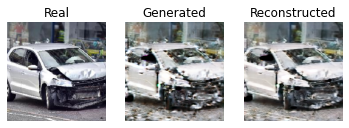

In [ ]:
# Importing libraries
from numpy import load
from numpy import expand_dims
from keras.models import load_model
from numpy.random import randint
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from matplotlib import pyplot
from numpy import vstack

def showPlot(imagesX, imagesY1, imagesY2):
	images = vstack((imagesX, imagesY1, imagesY2))
	titles = ['Real', 'Generated', 'Reconstructed']
	images = (images + 1) / 2.0
	for i in range(len(images)):
		pyplot.subplot(1, len(images), 1 + i)
		pyplot.axis('off')
		pyplot.imshow(images[i])
		pyplot.title(titles[i])
	pyplot.show()

def selectSample(dataset, nSamples):
	ix = randint(0, dataset.shape[0], nSamples)
	X = dataset[ix]
	return X

def loadImage(fileName, size=(256,256)):
	pixels = load_img(fileName, target_size=size)
	pixels = img_to_array(pixels)
	pixels = expand_dims(pixels, 0)
	pixels = (pixels - 127.5) / 127.5
	return pixels
 
# load the image
imageSRC = loadImage('/content/drive/MyDrive/FYP - CAR DAMAGE DETECTION/Dataset/08.04.2021/new_custom_dataset/Training/Broken/1.jpeg')
# load the model
cust = {'InstanceNormalization': InstanceNormalization}
modelAToB = load_model('/content/drive/MyDrive/FYP - CAR DAMAGE DETECTION/GANTraining/cyclegan_models/broken/broken_damage_vehicle_model_AtoB_072120.h5', cust)
modelBToA = load_model('/content/drive/MyDrive/FYP - CAR DAMAGE DETECTION/GANTraining/cyclegan_models/broken/broken_damage_vehicle_model_BtoA_072120.h5', cust)
AReal = selectSample(imageSRC, 1)
BGenerated  = modelAToB.predict(AReal)
AReconstructed = modelBToA.predict(BGenerated)
showPlot(AReal, BGenerated, AReconstructed)

In [ ]:
# Importing libraries
from numpy import load
from numpy import expand_dims
from keras.models import load_model
from numpy.random import randint
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from matplotlib import pyplot
from numpy import vstack
from PIL import Image
import os
import numpy as np

def showAndSavePlot(imagesX, imagesY1, imagesY2, originalFile, generatedFile):
	images = vstack((imagesX, imagesY1, imagesY2))
	titles = ['Real', 'Generated', 'Reconstructed']
	images = (images + 1) / 2.0
	for i in range(len(images)):
		pyplot.subplot(1, len(images), 1 + i)
		pyplot.axis('off')
		pyplot.imshow(images[i])
		pyplot.title(titles[i])
		if(i == 0):
				Image.fromarray(np.uint8((images[0])*255)).save(originalFile)
		elif (i == 2):
				Image.fromarray(np.uint8((images[2])*255)).save(generatedFile)
	pyplot.show()

def selectSample(dataset, nSamples):
	ix = randint(0, dataset.shape[0], nSamples)
	X = dataset[ix]
	return X

def loadImage(fileName, size=(256,256)):
	pixels = load_img(fileName, target_size=size)
	pixels = img_to_array(pixels)
	pixels = expand_dims(pixels, 0)
	pixels = (pixels - 127.5) / 127.5
	return pixels

print("Generating images in the folder")
cust = {'InstanceNormalization': InstanceNormalization}
modelAToB = load_model('/content/drive/MyDrive/FYP - CAR DAMAGE DETECTION/GANTraining/cyclegan_models/no_damage/no_damage_damage_vehicle_model_AtoB_060360.h5', cust)
modelBToA = load_model('/content/drive/MyDrive/FYP - CAR DAMAGE DETECTION/GANTraining/cyclegan_models/no_damage/no_damage_damage_vehicle_model_BtoA_060360.h5', cust)
folder = '/content/drive/MyDrive/FYP - CAR DAMAGE DETECTION/Dataset/NewCustomDatasetNonDup/Training/No Damage'
generatedFolder = '/content/drive/MyDrive/FYP - CAR DAMAGE DETECTION/Dataset/NewCustomDatasetNonDupGenerated/Training/No Damage'
for i in os.listdir(folder):
  file = f"{folder}/{i}"
  print(file)
  image_src = loadImage(file)
  AReal = selectSample(image_src, 1)
  BGenerated  = modelAToB.predict(AReal)
  AReconstructed = modelBToA.predict(BGenerated)
  originalFile = f"{generatedFolder}/{i}"
  generatedFile = f"{generatedFolder}/g_{i}"
  showAndSavePlot(AReal, BGenerated, AReconstructed, originalFile, generatedFile)

Generating images in the folder


OSError: ignored

In [ ]:
# Importing libraries
from numpy import load
from numpy import expand_dims
from keras.models import load_model
from numpy.random import randint
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from matplotlib import pyplot
from numpy import vstack
from PIL import Image
import os
import numpy as np

def showAndSavePlot(imagesX, imagesY1, imagesY2, originalFile, generatedFile):
	images = vstack((imagesX, imagesY1, imagesY2))
	titles = ['Real', 'Generated', 'Reconstructed']
	images = (images + 1) / 2.0
	for i in range(len(images)):
		pyplot.subplot(1, len(images), 1 + i)
		pyplot.axis('off')
		pyplot.imshow(images[i])
		pyplot.title(titles[i])
		if(i == 0):
				Image.fromarray(np.uint8((images[0])*255)).save(originalFile)
		# elif (i == 2):
		# 		Image.fromarray(np.uint8((images[2])*255)).save(generatedFile)
	pyplot.show()

def selectSample(dataset, nSamples):
	ix = randint(0, dataset.shape[0], nSamples)
	X = dataset[ix]
	return X

def loadImage(fileName, size=(256,256)):
	pixels = load_img(fileName, target_size=size)
	pixels = img_to_array(pixels)
	pixels = expand_dims(pixels, 0)
	pixels = (pixels - 127.5) / 127.5
	return pixels

print("Generating images in the folder")
cust = {'InstanceNormalization': InstanceNormalization}
modelAToB = load_model('/content/drive/MyDrive/FYP - CAR DAMAGE DETECTION/GANTraining/cyclegan_models/scratch/scratch_damage_vehicle_model_AtoB_030840.h5', cust)
modelBToA = load_model('/content/drive/MyDrive/FYP - CAR DAMAGE DETECTION/GANTraining/cyclegan_models/scratch/scratch_damage_vehicle_model_BtoA_030840.h5', cust)
folder = '/content/drive/MyDrive/FYP - CAR DAMAGE DETECTION/Dataset/NewCustomDatasetNonDup/Testing/No Damage'
generatedFolder = '/content/drive/MyDrive/FYP - CAR DAMAGE DETECTION/Dataset/NewCustomDatasetNonDupGenerated/Testing/No Damage'
for i in os.listdir(folder):
  file = f"{folder}/{i}"
  print(file)
  image_src = loadImage(file)
  AReal = selectSample(image_src, 1)
  BGenerated  = modelAToB.predict(AReal)
  AReconstructed = modelBToA.predict(BGenerated)
  originalFile = f"{generatedFolder}/{i}"
  generatedFile = f"{generatedFolder}/g_{i}"
  showAndSavePlot(AReal, BGenerated, AReconstructed, originalFile, generatedFile)